Proces uczenia modelu wykonałem w tym repozytorium: https://github.com/MarceliG/UMDDZ

Natomiast tutaj zaprezentuje jedynie proces evaluacji danych oraz ściągnięcie modelu, do samodzielnych eksperymentów

W terminalu proszę wpisać: `pip install -r requirements.txt`

In [17]:
import gdown
import torch
from datasets import DatasetDict, load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Compose, Normalize, Resize, ToTensor
from transformers import ViTImageProcessor
import matplotlib.pyplot as plt
import random
import logging
from torch import nn
from transformers import ViTModel
import numpy as np
from sklearn.metrics import confusion_matrix

Pobranie modelu automatycznie

In [3]:
file_id = "1VLQiX-cSylMWfR9WP9OGrXymc6-3vfqj"
output_path = "model.pth"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_path, quiet=False)

print("Pobieranie zakończone!")


Downloading...
From (original): https://drive.google.com/uc?id=1VLQiX-cSylMWfR9WP9OGrXymc6-3vfqj
From (redirected): https://drive.google.com/uc?id=1VLQiX-cSylMWfR9WP9OGrXymc6-3vfqj&confirm=t&uuid=41c86fd3-af4c-418e-befe-445385d32d18
To: /home/marceli/Study/ZMSI_sem_3/ML-EASY/model.pth
100%|██████████| 346M/346M [00:26<00:00, 13.3MB/s] 


Pobieranie zakończone!


Pobranie modelu manualnie:
https://drive.google.com/file/d/1VLQiX-cSylMWfR9WP9OGrXymc6-3vfqj/view?usp=sharing

In [4]:

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(filename)s | %(funcName)s() | %(message)s",
    datefmt="%m-%d-%Y %H:%M:%S",
)

logger = logging.getLogger()


In [5]:
class MultiModalClassifier(nn.Module):
    def __init__(self, num_metadata_features, num_classes):
        
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.metadata_fc = nn.Linear(num_metadata_features, 128)
        self.classifier = nn.Linear(self.vit.config.hidden_size + 128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, pixel_values, metadata, labels=None):
        vit_output = self.vit(pixel_values=pixel_values).last_hidden_state[:, 0, :]
        metadata_output = self.relu(self.metadata_fc(metadata))
        combined = torch.cat((vit_output, metadata_output), dim=1)
        logits = self.classifier(combined)

        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

        return logits


In [22]:
def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    cm = confusion_matrix(true_labels, predicted_labels)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap="Blues")
    fig.colorbar(cax)
    
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', color="white")
    
    plt.show()

def evaluate_model(preproced_dataset: DatasetDict) -> None:
    # Liczba cech metadata
    num_metadata_features = len(["dx", "dx_type", "sex", "localization"]) + 1
    # Liczba klas w etykietach
    num_labels = len(set(preproced_dataset["train"]["label"]))

    # Załadowanie modelu
    model = MultiModalClassifier(num_metadata_features, num_labels)
    model.load_state_dict(torch.load("model.pth"))
    model.eval()

    true_labels = []
    predicted_labels = []

    # Przewidywanie etykiet na danych testowych
    with torch.no_grad():
        for sample in preproced_dataset["test"]:
            pixel_values = torch.tensor(sample["pixel_values"], dtype=torch.float32).unsqueeze(0)
            metadata = torch.tensor(sample["metadata"], dtype=torch.float32).unsqueeze(0)

            output = model(pixel_values=pixel_values, metadata=metadata)
            probabilities = torch.nn.functional.softmax(output, dim=1)
            predicted_label = torch.argmax(probabilities, dim=1).item()

            true_labels.append(sample["label"])
            predicted_labels.append(predicted_label)

    # Obliczenie dokładności
    accuracy = accuracy_score(true_labels, predicted_labels)
    logger.info(f"\nAccuracy: {accuracy:.4f}\n")

    # Raport klasyfikacji
    logger.info("\nClassification Report:\n")
    logger.info(classification_report(true_labels, predicted_labels, digits=4))

    # Obliczenie i wyświetlenie macierzy konfuzji
    logger.info("\nConfusion Matrix:\n")
    plot_confusion_matrix(true_labels, predicted_labels, class_names=["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5", "Class 6"])

In [7]:
def process_dataset(dataset: DatasetDict) -> DatasetDict:
    processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

    categorical_columns = ["dx", "dx_type", "sex", "localization"]
    label_encoders = {col: LabelEncoder().fit(dataset["train"][col]) for col in categorical_columns}

    age_mean = sum(filter(None, dataset["train"]["age"])) / len(dataset["train"]["age"])
    age_std = (
        sum((x - age_mean) ** 2 for x in filter(None, dataset["train"]["age"])) / len(dataset["train"]["age"])
    ) ** 0.5

    def transform(example) -> DatasetDict:
        image = example["image"].convert("RGB")
        transforms = Compose([
            Resize((224, 224)),
            ToTensor(),
            Normalize(mean=processor.image_mean, std=processor.image_std),
        ])
        example["pixel_values"] = transforms(image)

        example["metadata"] = torch.tensor(
            [
                *[label_encoders[col].transform([example[col]])[0] for col in categorical_columns],
                (example["age"] - age_mean) / age_std if example["age"] is not None else 0.0,
            ],
            dtype=torch.float32,
        )
        example["label"] = label_encoders["dx"].transform([example["dx"]])[0]
        return example

    dataset = dataset.map(
        transform, remove_columns=["image", "image_id", "lesion_id", "dx", "dx_type", "age", "sex", "localization"]
    )
    dataset.save_to_disk("dataset_preprocessed_skin_cancer")
    return dataset


In [8]:
logger.info("Downloading dataset...")
dataset = load_dataset("marmal88/skin_cancer")
dataset.save_to_disk("dataset_skin_cancer")

03-09-2025 20:31:51 | INFO | 235454279.py | <module>() | Downloading dataset...


Saving the dataset (0/6 shards):   0%|          | 0/9577 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/2492 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1285 [00:00<?, ? examples/s]

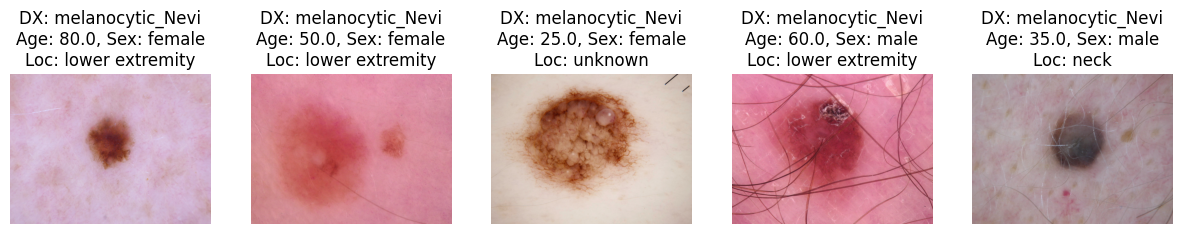

In [12]:
# Wybierz 5 losowych indeksów
random_indices = random.sample(range(len(dataset["train"])), 5)

# Wyświetl obrazy i ich metadane
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    sample = dataset["train"][idx]
    image = sample["image"]
    label = sample["dx"]  # Zmienna docelowa
    age = sample["age"]
    sex = sample["sex"]
    loc = sample["localization"]

    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"DX: {label}\nAge: {age}, Sex: {sex}\nLoc: {loc}")

plt.show()


In [13]:
preprocessed_dataset = process_dataset(dataset)
preprocessed_dataset = DatasetDict.load_from_disk("dataset_preprocessed_skin_cancer")

Saving the dataset (0/12 shards):   0%|          | 0/9577 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/2492 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/1285 [00:00<?, ? examples/s]

/tmp/ipykernel_8796/2727917820.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))
03-09-2025 20:46:03 | INFO | 2727917820.py

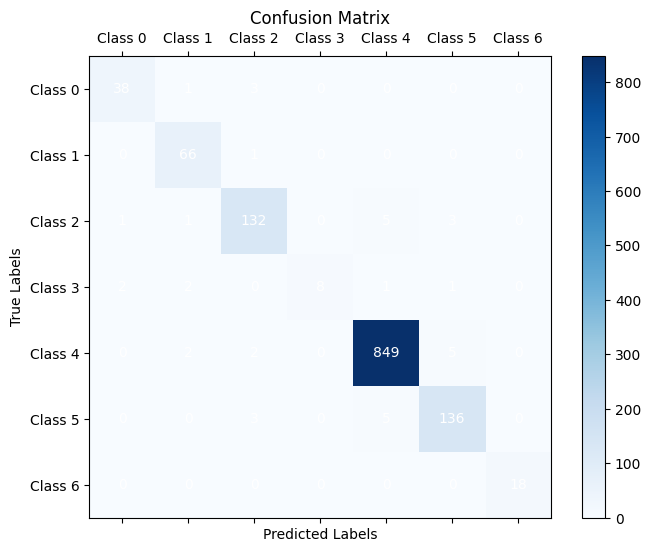

In [23]:
evaluate_model(preprocessed_dataset)